In [246]:
import torch
import torch.nn as nn
import numpy as np
from torch_geometric.datasets import KarateClub
from torch_geometric.utils.convert import to_networkx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import networkx as nx

In [284]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Karate Club Dataset

From "An Information Flow Model for Conflict and Fission in Small Groups" (https://www.journals.uchicago.edu/doi/epdf/10.1086/jar.33.4.3629752). About a karate club that feuded about their part time instructor "Mr. Hi" wanting to raise lesson prices while "John A." viewed it as trying to get a higher salary, until the club "completely and formally separated". The graph describes the affective friendships between club members (as opposed to effective: patron-client, kinship ties, etc). The labels come from modularity-based clustering (Brandes et al., 2008) (please don't ask me for a link) and are used in “Semi-supervised Classification with Graph Convolutional Networks” (https://arxiv.org/abs/1609.02907). The true Mr. Hi / John A. affiliation of members is available in `nx.karate_club_graph`, while the labels from clustering are in `KarateClub` from `torch_geometric.datasets`

In [ ]:
dataset = KarateClub()[0]

# x: # nodes x # features. In this case, x just a one-hot encoding of which number vertex it is (i.e. it's the identity matrix)
# edge_index: 156 edges
# y: labels for each node
# train_mask: which nodes should be used for training (originally, only four labels were used)
dataset

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])

In [111]:
E = dataset.edge_index.shape[1] # number of edges
V = dataset.x.shape[0] # number of vertices

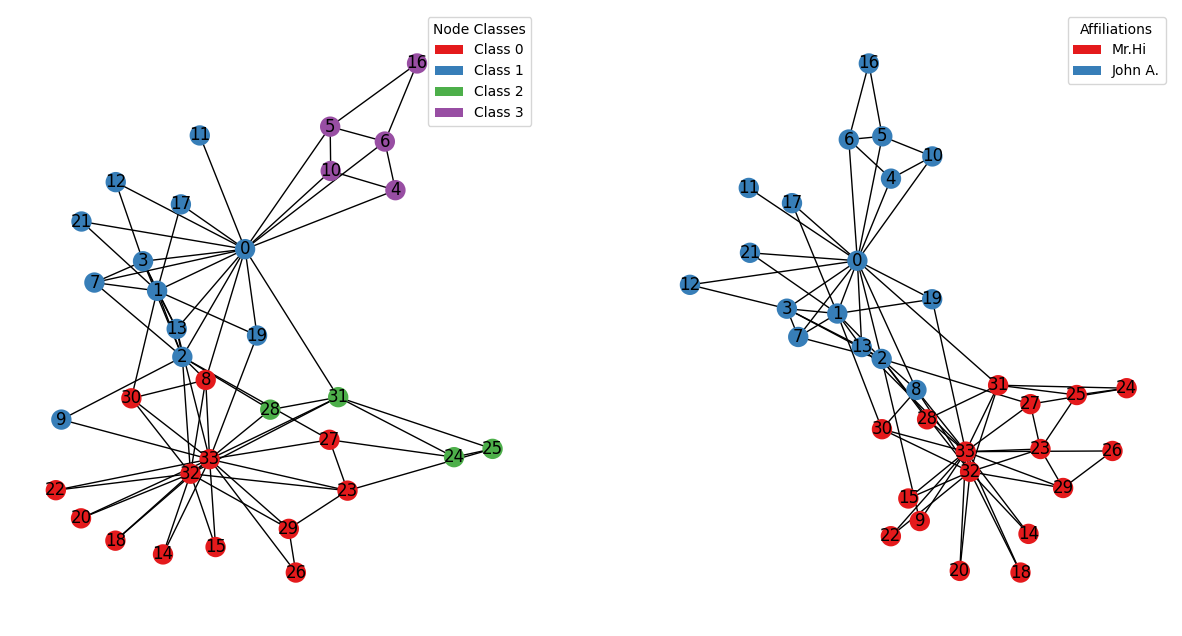

In [461]:
"""
Graph with 4 labels from clustering
"""
def plot_karate_graph_cluster_labels(ax, node_colors=None):
    karate_graph = to_networkx(dataset, to_undirected=True)
    labels = dataset.y

    # Set node colors
    num_classes = labels.max().item() + 1
    cmap = plt.cm.Set1
    if node_colors is None:
        node_colors = [cmap(label) for label in labels]

    # Draw Graph
    pos = nx.spring_layout(karate_graph, seed=42) # fix layout
    nx.draw(karate_graph, pos=pos, node_color=node_colors, node_size=75, linewidths=6, with_labels=True, ax=ax) # with_labels=True

    # Create legend
    legend_elements = [
        Patch(facecolor=cmap(i), label=f'Class {i}')
        for i in range(num_classes)
    ]
    ax.legend(handles=legend_elements, title="Node Classes", loc='upper right')

    return node_colors

"""
Graph with Mr.Hi / John A. Affiliations
"""
def plot_karate_graph_affiliations(ax):
    G = nx.karate_club_graph()
    affiliations = [0 if G.nodes[i]['club'] == 'Mr. Hi' else 1 for i in G.nodes]
    labels = ["Mr.Hi", "John A."]

    cmap = plt.cm.Set1
    node_colors = [cmap(1 - label) for label in affiliations] # "1 -" so colours match up between graphs better

    pos = nx.spring_layout(G, seed=42) # fix layout
    nx.draw(G, pos=pos, node_color=node_colors, node_size=75, linewidths=6, with_labels=True, ax=ax) # with_labels=True

    # Create legend
    legend_elements = [
        Patch(facecolor=cmap(i), label=labels[i])
        for i in range(2)
    ]
    ax.legend(handles=legend_elements, title="Affiliations", loc='upper right')

    return node_colors

fig, axs = plt.subplots(1, 2, figsize=(15, 8))  # 1 row, 2 columns
plot_karate_graph_cluster_labels(axs[0])
plot_karate_graph_affiliations(axs[1])
plt.show()

We can see how Class 3 and Class 1 roughly correspond to those who support John A., and Class 0 and Class 2 roughly correspond to those who support Mr. Hi. Looks like vertices 2 and 9 are incorrect in clustering

### Adjacency Matrix

In [129]:
adj_matrix = np.zeros((V, V), dtype=int)

rows, cols = dataset.edge_index
adj_matrix[rows, cols] = 1
adj_matrix

# Check it looks the same
# G = nx.from_numpy_array(adj_matrix)
# pos = nx.spring_layout(karate_graph, seed=42) # fix layout
# nx.draw(karate_graph, pos=pos, node_color=node_colors, node_size=75, linewidths=6, with_labels=True)

array([[0, 1, 1, ..., 1, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 1, 0],
       ...,
       [1, 0, 0, ..., 0, 1, 1],
       [0, 0, 1, ..., 1, 0, 1],
       [0, 0, 0, ..., 1, 1, 0]])

### Adjacency List

In [181]:
# From edge_index
adj_list = [list() for _ in range(V)]

for i in range(E):
    edge = dataset.edge_index[:,i] # (source node, destination node)
    adj_list[edge[0]].append(edge[1].item())

# or
# for src, dst in zip(dataset.edge_index[0], dataset.edge_index[1]):
#     adj_list[src.item()].append(dst.item())

adj_list[:5]

[[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 17, 19, 21, 31],
 [0, 2, 3, 7, 13, 17, 19, 21, 30],
 [0, 1, 3, 7, 8, 9, 13, 27, 28, 32],
 [0, 1, 2, 7, 12, 13],
 [0, 6, 10]]

In [183]:
# From adjacency matrix
adj_list = [np.where(adj_matrix[i,:] == 1)[0] for i in range(V)]

# or
# adj_list = [row.nonzero()[0].tolist() for row in adj_matrix]

adj_list[:5]

[array([ 1,  2,  3, ..., 19, 21, 31], dtype=int64),
 array([ 0,  2,  3, ..., 19, 21, 30], dtype=int64),
 array([ 0,  1,  3, ..., 27, 28, 32], dtype=int64),
 array([ 0,  1,  2,  7, 12, 13], dtype=int64),
 array([ 0,  6, 10], dtype=int64)]

## Deep Walk
From Deep Walk: Online Learning of Social Representations

In [399]:
# generates a random walk of length "length", starting at "start_node" in a graph described by "adj_list"
def random_walk(adj_list, start_node, length):
    walk = np.empty(length, dtype=int)
    walk[0] = start_node

    for i in range(1, length): # - 1 because we start with one node
        walk[i] = np.random.choice(adj_list[walk[i - 1]])

    return walk

# start_nodes is n x 1
# returned walks is n x length
def vectorized_random_walk(adj_list, start_nodes, length):
    walks = start_nodes.reshape(-1, 1) # ensure correct shape
    last = start_nodes

    for i in range(length - 1):
        # nexts = 
        pass

walk = random_walk(adj_list, 0, 5)
walk

array([ 0, 12,  0, 31, 32])

In [422]:
# skip - how far left and right from the current vertex do we look
# gram refers to the current slice we're looking at (i - skip : i + skip)
# note that (v, v) is included in the pairs
def skip_gram(walk, skip):
    pairs = np.array([], dtype=int)
    # length = len(walk)
    # skip = min(skip, length)

    # num_pairs = length + skip * (2 * length - skip - 1)
    # pairs = np.empty(num_pairs * 2, dtype=int)

    idx = 0
    for i, v in enumerate(walk):
        min_index = max(0, i - skip)
        max_index = min(len(walk) - 1, i + skip)

        for u in walk[min_index:max_index + 1]:
            pairs = np.append(pairs, np.array([v, u]))
            # pairs[[idx,idx+1]] = [v, u]
            # idx += 2
    
    return pairs.reshape(-1, 2)

pairs = skip_gram(walk, 3)
pairs.shape

(23, 2)

In [ ]:


skip = 4
length = 5

# length + (length - 2 * skip) * skip + skip * (skip - 1) + length * skip
# length * (1 + skip + length - 2*skip) + skip * (skip - 1)
length + skip * (2 * length - skip - 1)
# length * (1 + length - skip) + skip * (skip - 1)

25

In [ ]:
def pairs_to_one_hot(pairs, V):
    num_pairs = pairs.shape[0]

    train_one_hot = np.zeros((num_pairs, V))
    target_one_hot = np.zeros((num_pairs, V))

    # np.put works on a flattened array
    # V * np.arange(num_pairs) gives the first element of each row
    # + pairs gives which the column
    train_indices = pairs[:,0] + V * np.arange(num_pairs)
    target_indices = pairs[:,1] + V * np.arange(num_pairs)

    np.put(train_one_hot, train_indices, 1)
    np.put(target_one_hot, target_indices, 1)

    return train_one_hot, target_one_hot

train_one_hot, target_one_hot = pairs_to_one_hot(pairs, V)


In [249]:
class DeepWalkNeuralNetwork(nn.Module):

    def __init__(self, input_size, latent_space):
        super().__init__()
        self.h = nn.Sequential(
            nn.Linear(input_size, latent_space),
            nn.ReLU(),
            nn.Linear(latent_space, input_size),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.h(x)

In [ ]:
# assumes data is already shuffled
def get_mini_batch(data, batch_size):

    for i in range(int(len(data) / batch_size) + 1):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(data)) # end_idx is exclusive

        yield(data[start_idx:end_idx])

gen = get_mini_batch(np.arange(V), 16)

for batch in gen:
    print(batch)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31]
[32 33]
34


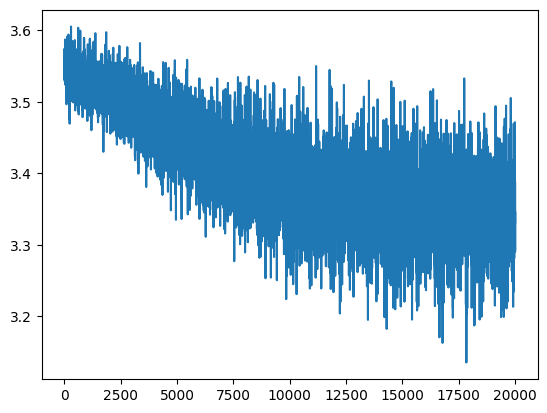

In [454]:
def deep_walk(adj_list, V, model, num_epochs, batch_size, walk_length, skip):
    loss_fn = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(), lr=1e-4)
    losses = []

    for epoch in range(num_epochs):

        # shuffle order of vertices
        vertices = np.arange(V)
        np.random.shuffle(vertices)

        batches = get_mini_batch(vertices, batch_size)
        for batch_vertices in batches:

            walks = [random_walk(adj_list, v, walk_length) for v in batch_vertices]
            pairs = np.array([skip_gram(walk, skip) for walk in walks], dtype=int).reshape(-1,2)
            x, y = pairs_to_one_hot(pairs, V)
            
            # convert to tensors for training
            x = torch.from_numpy(x).type(torch.FloatTensor).to(device)
            y = torch.from_numpy(y).type(torch.FloatTensor).to(device)

            # train step
            opt.zero_grad()
            preds = model(x)
            loss = loss_fn(preds, y)
            loss.backward()
            opt.step()

            losses.append(loss.item())
    
    return losses

device = "cpu" # cpu is faster, cuz otherwise moving a lot of data back and forth (fix this later maybe)
model = DeepWalkNeuralNetwork(V, 2).to(device)
losses = deep_walk(adj_list, V, model, 4000, 8, 7, 5)
plt.plot(losses)


In [446]:
params = next(model.parameters())
print(params.shape) # note: (latent_dim, input_size) because torch uses the transpose for some reason
print(params)

torch.Size([2, 34])
Parameter containing:
tensor([[-0.4387039542, -0.4382301867,  0.2857230306, -0.3369479477,
         -0.4383196235, -0.4381645322, -0.4388612211, -0.4379932582,
          0.6973987818,  0.3442326188, -0.4386864305, -0.4379726350,
         -0.4369342923, -0.4384781122,  0.0862591788,  0.4025803804,
         -0.4389918149, -0.4381299317,  0.5905928016, -0.4381651282,
          0.2655173242, -0.4380314350,  0.1248490736,  0.9252175093,
          0.4236817658,  0.8177923560,  0.4124803543,  0.4531348348,
          0.8244946003,  0.7097795606,  0.4001774192,  0.3441553712,
          0.6890805960,  0.5319532156],
        [ 0.7008785009,  0.4941843748,  0.9216576815,  0.4871551692,
         -0.7276434302, -0.6372792125, -0.6025509834,  0.7619054317,
          0.4626587033,  0.6055605412, -0.6228398681,  0.6461551785,
         -0.1139842346,  0.3339962959,  0.4812093079,  0.6868911982,
         -0.7542375326,  0.1191096604,  0.6296291351,  0.5855166316,
          0.623826324

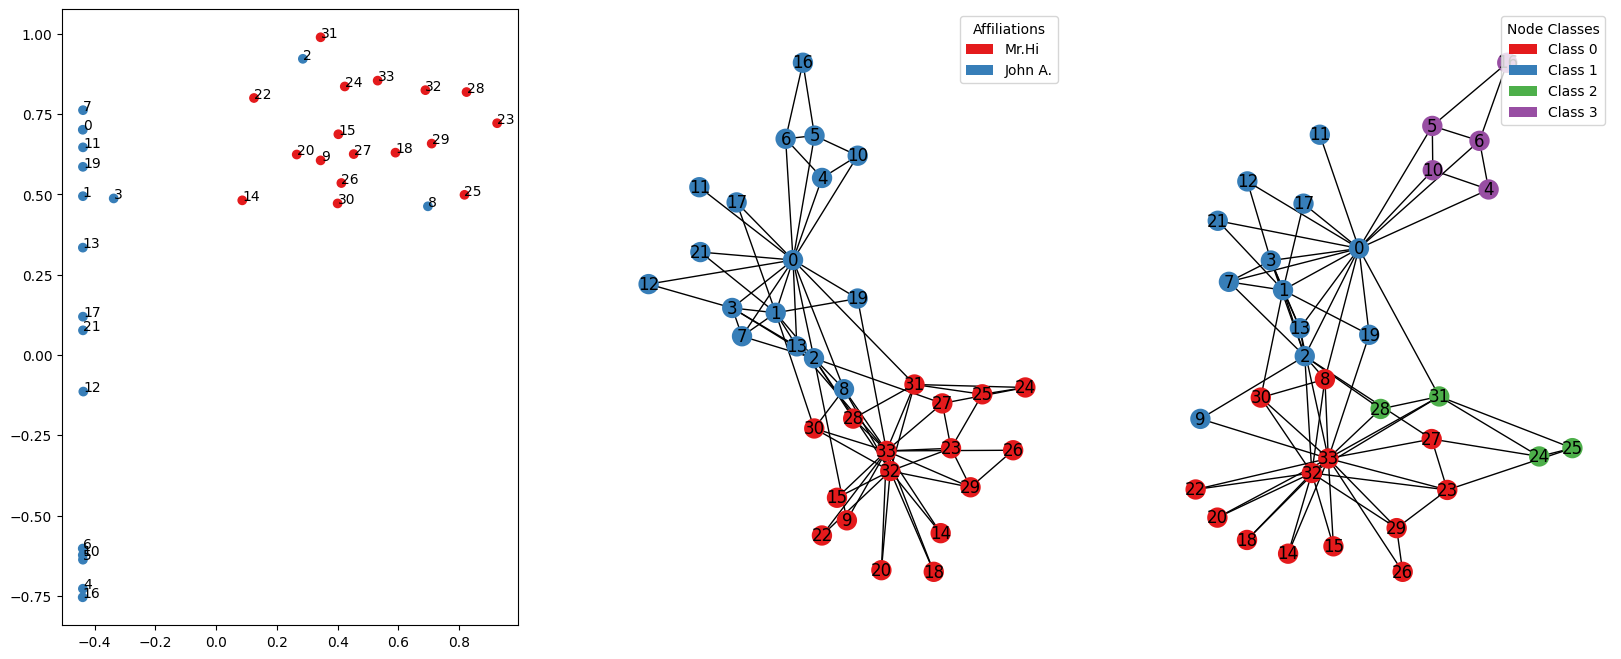

In [455]:
def plot_embeddings(embeddings, node_colors, ax):
    ax.scatter(embeddings[0], embeddings[1], c=node_colors)
    for i in range(V):
        ax.text(embeddings[0,i], embeddings[1,i], i)

embeddings = params.detach()

fig, axs = plt.subplots(1, 3, figsize=(20, 8))
affiliation_node_colors = plot_karate_graph_affiliations(axs[1])
plot_karate_graph_cluster_labels(axs[2])
plot_embeddings(embeddings, affiliation_node_colors, axs[0])

plt.show()


### Kmeans on embeddings

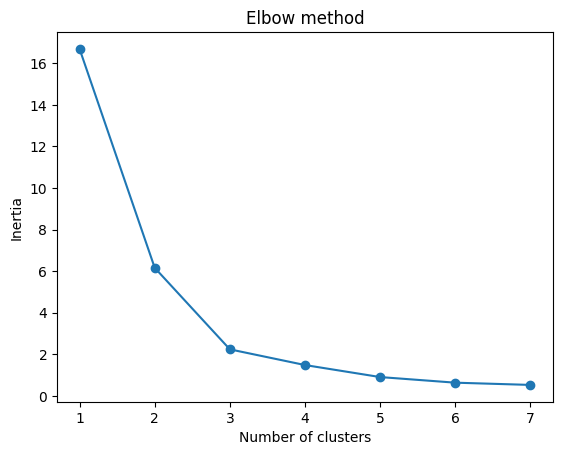

In [448]:
from sklearn.cluster import KMeans

train_embeddings = list(zip(embeddings[0], embeddings[1])) # convert embeddings to list
inertias = [] # Sum of squared distances of samples to their closest cluster center

for i in range(1, 8):
    kmeans = KMeans(n_clusters=i, n_init=50)
    kmeans.fit(train_embeddings)

    inertias.append(kmeans.inertia_)

plt.plot(range(1,8), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

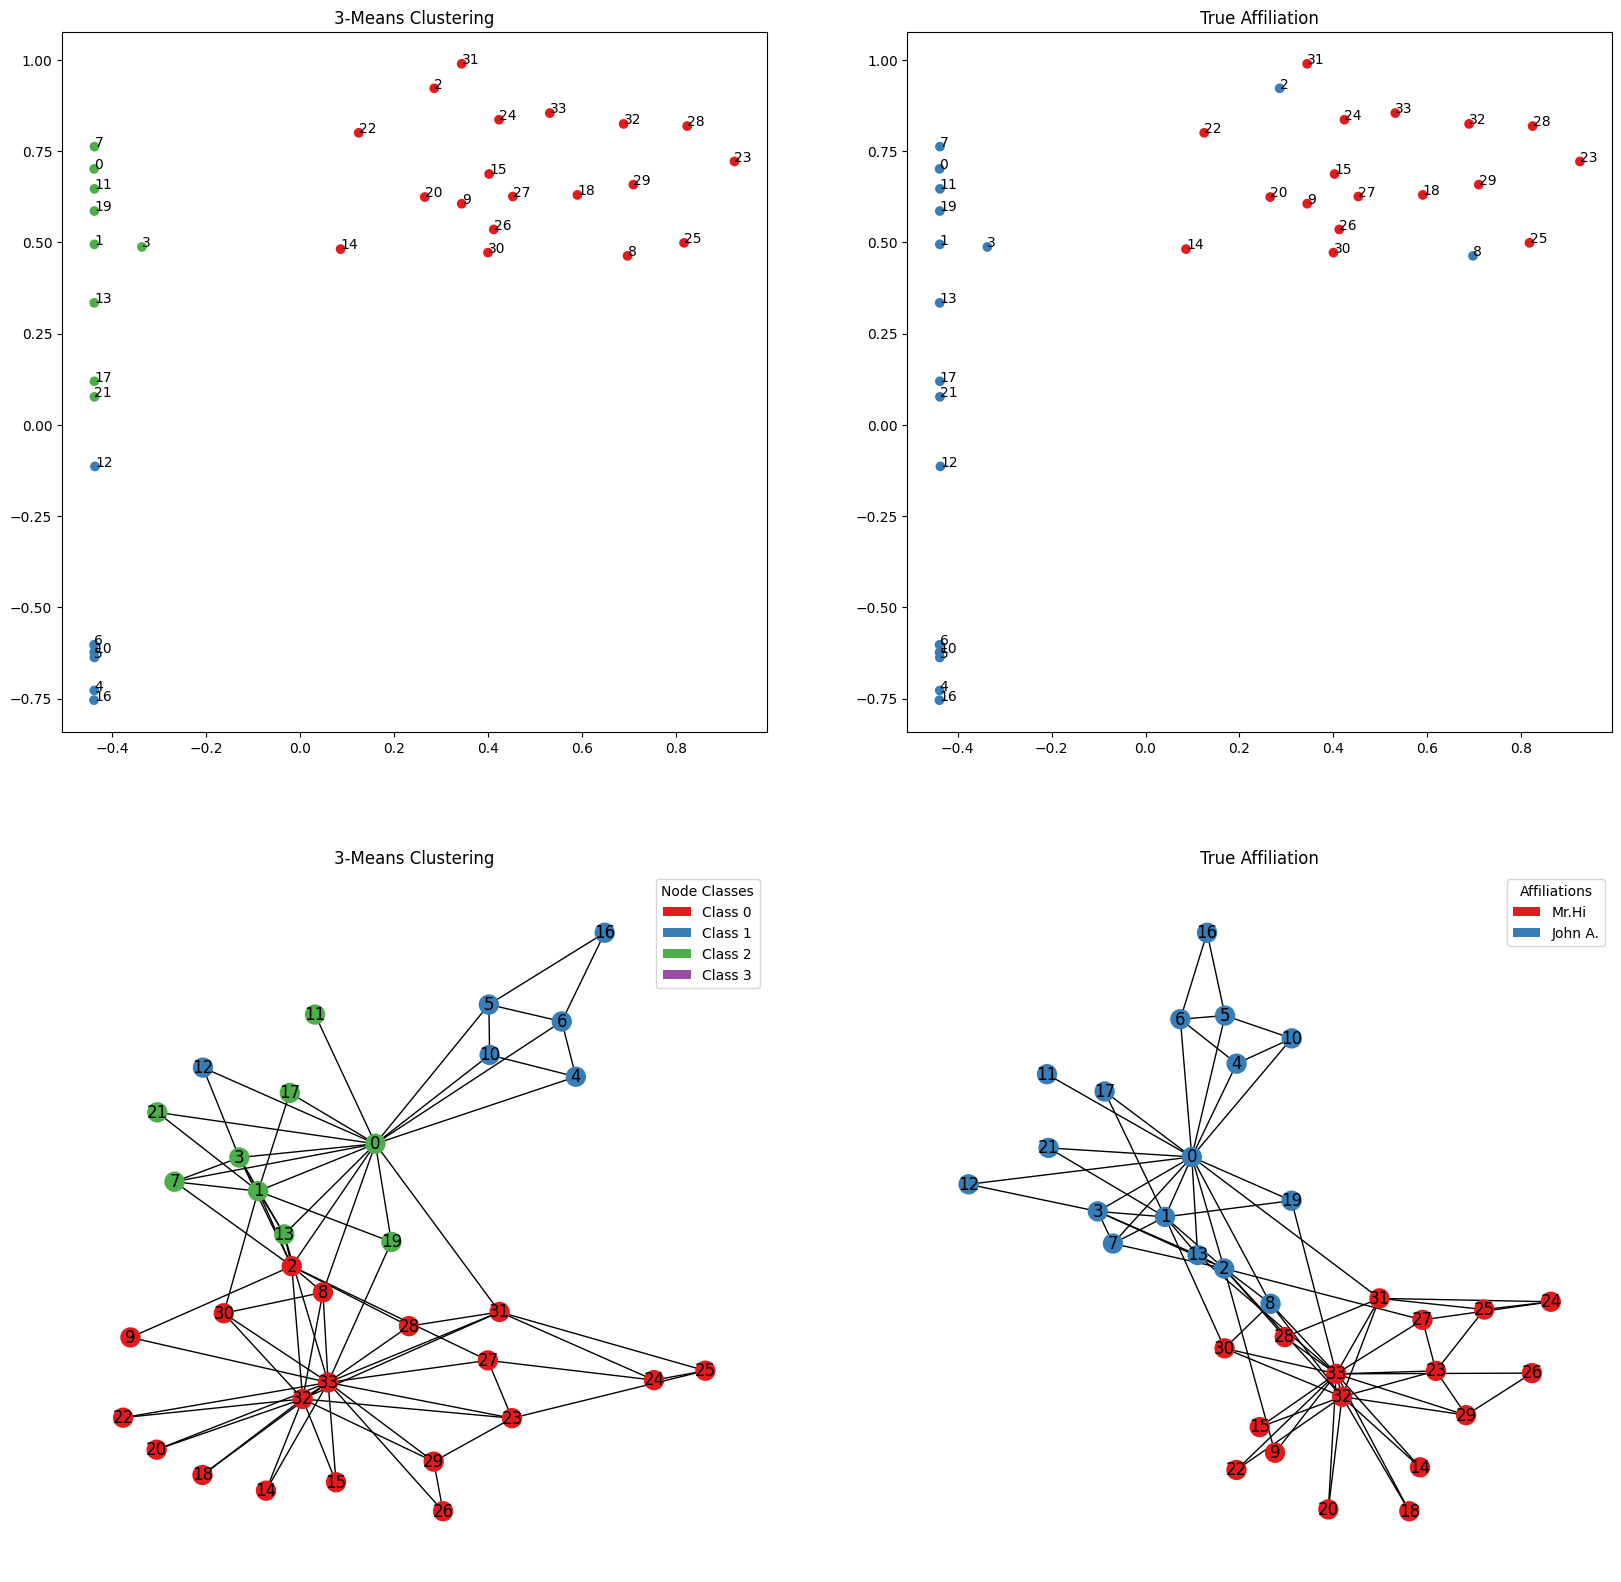

In [464]:
k = 3
kmeans = KMeans(n_clusters=3, n_init=50)
kmeans.fit(train_embeddings)

cmap = plt.cm.Set1
node_colors = [cmap(label) for label in kmeans.labels_]

fig, axs = plt.subplots(2, 2, figsize=(20, 20))

# Embeddings
plot_embeddings(embeddings, node_colors, axs[0,0])
plot_embeddings(embeddings, affiliation_node_colors, axs[0,1])
axs[0,0].set_title(f"{k}-Means Clustering")
axs[0,1].set_title("True Affiliation")

# Graphs
plot_karate_graph_cluster_labels(axs[1,0], node_colors=node_colors)
plot_karate_graph_affiliations(axs[1,1])
axs[1,0].set_title(f"{k}-Means Clustering")
axs[1,1].set_title("True Affiliation")

plt.show()